In [1]:
import zipfile
import os

# 定義 ZIP 檔案名稱
zip_file_name = "recodai-luc-scientific-image-forgery-detection.zip"

# 定義解壓縮後的資料夾名稱 (通常是檔案名稱去尾綴)
# 我們將解壓縮到名為 'dataset' 的資料夾，如果它不存在
extract_dir = "dataset" 

# 檢查 ZIP 檔案是否存在
if not os.path.exists(zip_file_name):
    print(f"錯誤：找不到檔案 {zip_file_name}。請確認檔案是否在當前工作目錄。")
else:
    # 檢查資料夾是否已經存在，避免重複解壓縮
    if not os.path.exists(extract_dir):
        print(f"正在解壓縮 {zip_file_name} 到 {extract_dir}...")
        try:
            with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
                # 假設 ZIP 檔案內部的頂層目錄就是我們需要的資料夾
                zip_ref.extractall(extract_dir)
            print("解壓縮完成！")
        except Exception as e:
            print(f"解壓縮時發生錯誤: {e}")
    else:
        print(f"資料夾 {extract_dir} 已經存在，跳過解壓縮步驟。")

資料夾 dataset 已經存在，跳過解壓縮步驟。


In [2]:
import pandas as pd
import os
import glob
from tqdm import tqdm

# 定義基礎路徑
BASE_DIR = 'dataset'
AUTHENTIC_IMG_DIR = os.path.join(BASE_DIR, 'train_images', 'authentic')
TRAIN_IMG_DIR = os.path.join(BASE_DIR, 'train_images', 'forged') # 已配對的 Forged 來源
TRAIN_MASK_DIR = os.path.join(BASE_DIR, 'train_masks')

# ----------------------------------------------------
# 0. 讀取並整合 FORGED (偽造) 影像
# ----------------------------------------------------
forged_data = []

# 獲取所有 FORGED 影像的檔案路徑
# 由於 Forged 影像和 Mask 檔案名稱應一致 (不含副檔名)，我們可以通過圖像路徑來配對。
forged_img_paths = glob.glob(os.path.join(TRAIN_IMG_DIR, '*.PNG'))
forged_img_paths.extend(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.png'))) # 確保涵蓋小寫

print(f"\n正在整理 {len(forged_img_paths)} 張 Forged 影像並配對 Mask...")

for img_path in tqdm(forged_img_paths, desc="整理 Forged 影像"):
    # 獲取 case_id (不含副檔名)
    case_id = os.path.splitext(os.path.basename(img_path))[0]
    
    # 尋找對應的 Mask 路徑 (.npy 格式)
    # Mask 檔案通常在 TRAIN_MASK_DIR 下，以 case_id 命名
    mask_path = os.path.join(TRAIN_MASK_DIR, case_id + '.npy')
    
    # 檢查 Mask 檔案是否存在（避免數據損壞）
    if os.path.exists(mask_path):
        forged_data.append({
            'case_id': case_id,
            'image_path': img_path,
            'mask_path': mask_path, # Forged 影像有 Mask
            'label': 1              # Forged 標記為 1 (偽造)
        })
    # 如果找不到 Mask，通常表示數據不完整，可以跳過或記錄錯誤
    # else:
        # print(f"警告：找不到 {case_id} 的 Mask 檔案。")


df_forged = pd.DataFrame(forged_data)
print(f"✅ 成功整理 {len(df_forged)} 張 Forged 影像及其 Mask。")

# ----------------------------------------------------
# 1. 讀取並整合 AUTHENTIC (真實) 影像
# ----------------------------------------------------
authentic_data = []

# 獲取所有 AUTHENTIC 影像的檔案路徑 (*.PNG 格式)
authentic_paths = glob.glob(os.path.join(AUTHENTIC_IMG_DIR, '*.PNG'))
authentic_paths.extend(glob.glob(os.path.join(AUTHENTIC_IMG_DIR, '*.png'))) # 確保涵蓋小寫

print(f"\n正在整理 {len(authentic_paths)} 張 Authentic 影像...")

for img_path in tqdm(authentic_paths, desc="整理 Authentic 影像"):
    # 獲取 case_id
    case_id = os.path.splitext(os.path.basename(img_path))[0]
    
    authentic_data.append({
        'case_id': case_id,
        'image_path': img_path,
        'mask_path': None, # Authentic 影像沒有偽造 Mask
        'label': 0        # Authentic 標記為 0 (真實)
    })

df_authentic = pd.DataFrame(authentic_data)
print(f"✅ 成功整理 {len(df_authentic)} 張 Authentic 影像。")

# ----------------------------------------------------
# 2. 合併 Forged 和 Authentic 數據集
# ----------------------------------------------------

# (重新定義 df_forged 以便在當前環境中使用，假設您已經成功創建)
# 這裡使用您提供的 5502 筆數據作為 df_forged

# 如果 df_forged 在當前執行環境中不存在，則需要重新運行配對程式碼，
# 這裡假設 df_forged 已經在您的環境中定義並包含 5502 筆數據。

# 完整的訓練集
df_train_full = pd.concat([df_forged, df_authentic], ignore_index=True)

print("\n--- 完整訓練集 (Forged + Authentic) ---")
print(f"總訓練樣本數: {len(df_train_full)}")
print(f"Forged 樣本數: {len(df_forged)}")
print(f"Authentic 樣本數: {len(df_authentic)}")
print("--- 完整資料框頭部 (Head) ---")
print(df_train_full.head())
print("--- 完整資料框尾部 (Tail) ---")
print(df_train_full.tail())


正在整理 5502 張 Forged 影像並配對 Mask...


整理 Forged 影像: 100%|██████████| 5502/5502 [00:00<00:00, 48779.53it/s]


✅ 成功整理 5502 張 Forged 影像及其 Mask。

正在整理 4754 張 Authentic 影像...


整理 Authentic 影像: 100%|██████████| 4754/4754 [00:00<00:00, 301249.75it/s]

✅ 成功整理 4754 張 Authentic 影像。

--- 完整訓練集 (Forged + Authentic) ---
總訓練樣本數: 10256
Forged 樣本數: 5502
Authentic 樣本數: 4754
--- 完整資料框頭部 (Head) ---
  case_id                             image_path  \
0      10     dataset\train_images\forged\10.png   
1   10015  dataset\train_images\forged\10015.png   
2   10017  dataset\train_images\forged\10017.png   
3   10030  dataset\train_images\forged\10030.png   
4   10070  dataset\train_images\forged\10070.png   

                       mask_path  label  
0     dataset\train_masks\10.npy      1  
1  dataset\train_masks\10015.npy      1  
2  dataset\train_masks\10017.npy      1  
3  dataset\train_masks\10030.npy      1  
4  dataset\train_masks\10070.npy      1  
--- 完整資料框尾部 (Tail) ---
      case_id                               image_path mask_path  label
10251    9954  dataset\train_images\authentic\9954.png      None      0
10252    9960  dataset\train_images\authentic\9960.png      None      0
10253    9967  dataset\train_images\authentic\9967.png    

In [3]:
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms as T

# 由於圖像和 Mask 尺寸可能會很大，我們需要統一的預處理。
# 假設所有圖像都被調整到標準尺寸，例如 256x256
IMG_SIZE = 256

class ForgeryDetectionDataset(Dataset):
    """
    用於圖像偽造檢測分割任務的 PyTorch Dataset
    讀取 PNG 圖像和 NPY Mask。
    """
    def __init__(self, df: pd.DataFrame, img_size=IMG_SIZE):
        self.df = df
        self.img_size = img_size
        
        # 圖像預處理：Resize, 轉為 Tensor, 並進行標準化
        self.image_transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(), # 將 (H, W, C) 圖像轉為 (C, H, W) Tensor，並標準化到 [0, 1]
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet 標準化
        ])
        
        # Mask 預處理：Resize, 轉為 Tensor。Mask 不需要標準化
        self.mask_transform = T.Compose([
            # T.ToPILImage(), # NPY 讀取後可能是 NumPy array，先轉為 PIL 圖像才能 Resize
            T.Resize((img_size, img_size), interpolation=Image.NEAREST), # Mask 必須使用最近鄰插值
            # T.ToTensor() # 將 (H, W) Mask 轉為 (1, H, W) Tensor
        ])
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 1. 處理圖像
        image = Image.open(row['image_path']).convert("RGB")
        image_tensor = self.image_transform(image)
        
        # 2. 處理 Mask
        mask_path = row['mask_path']
        
        if mask_path is not None:
            # Forged 圖像：讀取 NPY 檔案
            mask_np = np.load(mask_path).astype(np.uint8)
            
            # 1. 移除所有尺寸為 1 的維度 (例如 (1, H, W, 1) -> (H, W))
            mask_np = mask_np.squeeze() 
            
            # 2. 如果陣列仍然是 3D (例如 (H, W, 3))，強制只取第一個通道
            if mask_np.ndim == 3:
                mask_np = mask_np[..., 0] # 選擇第一個通道 (灰度信息)
                
            # 3. 檢查最終維度，若不為 2 則報錯，幫助調試
            if mask_np.ndim != 2:
                # 這應該不會發生，除非數據本身是 4D 或更多
                raise ValueError(f"Mask 維度處理失敗，最終維度: {mask_np.shape}")

            # 手動將 NumPy 陣列轉換為 PIL 圖像
            mask_img = Image.fromarray(mask_np)

            # 調整部分
            mask_img = T.Resize((self.img_size, self.img_size), interpolation=Image.NEAREST)(mask_img)
            mask_tensor = torch.from_numpy(np.array(mask_img)).unsqueeze(0).float()
            mask_tensor = (mask_tensor > 0).float()
            
        else:
            # Authentic 圖像：創建一個全 0 的 Mask
            # 必須創建 (1, H, W) 格式的 Tensor，與 Mask 輸出的 Channel 數一致
            mask_tensor = torch.zeros((1, self.img_size, self.img_size), dtype=torch.float32)

        # 返回圖像 Tensor 和 Mask Tensor
        # 在分割任務中，Label (0/1) 資訊主要在 Mask 裡 (0 = 背景, 1 = 偽造區域)
        return image_tensor, mask_tensor

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
import numpy as np

# 1. 劃分數據集
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2
RANDOM_SEED = 42
BATCH_SIZE = 8

# 使用分層抽樣確保 Forged 和 Authentic 樣本在訓練集和驗證集中比例大致相同
df_train_sub, df_val_sub = train_test_split(
    df_train_full, 
    test_size=VAL_RATIO, 
    random_state=RANDOM_SEED, 
    stratify=df_train_full['label']
)

print(f"\n--- 資料集劃分結果 ---")
print(f"訓練集總樣本數: {len(df_train_sub)} ({len(df_train_sub[df_train_sub['label']==1])} Forged)")
print(f"驗證集總樣本數: {len(df_val_sub)} ({len(df_val_sub[df_val_sub['label']==1])} Forged)")


# 2. 實例化 Dataset
train_dataset = ForgeryDetectionDataset(df_train_sub, img_size=IMG_SIZE)
val_dataset = ForgeryDetectionDataset(df_val_sub, img_size=IMG_SIZE)

# 調整部分
train_labels = df_train_sub['label'].values
class_counts = np.array([len(np.where(train_labels == t)[0]) for t in [0, 1]])
total_samples = len(train_labels)
weights = 1.0 / class_counts
sample_weights = np.array([weights[t] for t in train_labels])
sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=total_samples, # 確保一個 Epoch 樣本總數不變
    replacement=True           # 允許重複採樣 (必須的)
)


# 3. 創建 DataLoader
BATCH_SIZE = 8 # 從 8 開始測試

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    # shuffle=True,
    sampler=sampler,
    num_workers=0, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

print(f"\n✅ DataLoader 創建完成。Batch Size: {BATCH_SIZE}。")


--- 資料集劃分結果 ---
訓練集總樣本數: 8204 (4401 Forged)
驗證集總樣本數: 2052 (1101 Forged)

✅ DataLoader 創建完成。Batch Size: 8。


In [5]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch
from torch.optim import AdamW
from transformers import Dinov2Model, Dinov2Config
import torch.nn.functional as F

# 確保 CUDA 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 1. 改用 DeepLabV3+ (捕捉多尺度細節)
# ==========================================
# Encoder 換成 efficientnet-b4 (CNN)，它對紋理雜訊比 Transformer 更敏感
# 且 DeepLabV3+ 的 Atrous Convolution 能保持更好的解析度
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b4",  
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)


# ==========================================
# 2. 定義加權損失函數 (解決 F1 上不去的主因)
# ==========================================
class WeightedCombinedLoss(nn.Module):
    def __init__(self, pos_weight_value=5.0):
        super().__init__()
        
        # BCE Loss 加上 pos_weight
        # 這會讓模型對 "Label=1 (偽造)" 的錯誤懲罰加重 5 倍
        self.pos_weight = torch.tensor([pos_weight_value]).to(device)
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        
        # Dice Loss (專注於形狀重疊)
        self.dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
        
        # Focal Loss (專注於難分類的樣本)
        self.focal_loss = smp.losses.FocalLoss(mode='binary')

    def forward(self, pred, target):
        # 組合三種 Loss
        bce = self.bce_loss(pred, target)
        dice = self.dice_loss(pred, target)
        focal = self.focal_loss(pred, target)
        
        # 權重分配：加重 Dice 和 Focal，因為它們對 F1 提升最有幫助
        return 0.2 * bce + 0.4 * dice + 0.4 * focal

# 初始化
criterion = WeightedCombinedLoss(pos_weight_value=5.0) # 強迫模型關注偽造區域
optimizer = AdamW(model.parameters(), lr=1e-4) # CNN 可以用稍大一點的 LR

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Scheduler 稍微調寬鬆一點
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

print("✅ 模型與Loss準備完成 (DeepLabV3+ w/ EfficientNet)")

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

C:\Users\user\anaconda3\envs\pytorch_gpu\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--smp-hub--efficientnet-b4.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

✅ 模型與Loss準備完成 (DeepLabV3+ w/ EfficientNet)


In [6]:
from tqdm.auto import tqdm
import torch.nn.functional as F
import segmentation_models_pytorch as smp

# 定義訓練一個 Epoch 的函數
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # 設定為訓練模式
    running_loss = 0.0
    
    # 使用 tqdm 顯示進度條
    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device) # Mask (Target) 也要移動到 GPU
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向傳播 (Forward Pass)
        outputs = model(images) # 輸出 Logits
        
        # 計算損失
        loss = criterion(outputs, masks)
        
        # 後向傳播 (Backward Pass)
        loss.backward()
        
        # 更新權重
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def dice_score(pred, target, eps=1e-7):
    pred = pred.float()
    target = target.float()
    
    # 展平維度，方便計算總和
    pred_flat = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)

    # 總聯集 (Total Union)
    union_total = target_flat.sum() + pred_flat.sum()

    # 如果 target 和 pred 的所有像素總和都為 0，則 Dice = 1.0
    if union_total.item() == 0:
        return torch.tensor(1.0, device=pred.device) # 正確的負例預測

    # 交集 (Intersection)
    intersection = (pred_flat * target_flat).sum()
    
    # Dice = (2 * Intersection + eps) / (Union + eps)
    dice = (2 * intersection + eps) / (union_total + eps)
    
    # 重新調整為針對 batch 中每個樣本進行計算：
    intersection_batch = (pred * target).sum(dim=(1,2,3))
    union_batch = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    
    # 檢查是否所有樣本都為空集
    if union_batch.sum().item() == 0:
        return torch.tensor(1.0, device=pred.device) 

    dice_batch = (2 * intersection_batch + eps) / (union_batch + eps)
    return dice_batch.mean()

# 定義驗證一個 Epoch 的函數
def val_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_dice = 0.0 # 替換 val_metrics = {'f1_score': 0.0}
    total_samples = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

            # sigmoid + threshold (必須步驟)
            prob = torch.sigmoid(outputs)
            pred = (prob > 0.5).float()

            # Dice / F1 (替換 smp.metrics)
            dice = dice_score(pred, masks)

            total_dice += dice.item() * images.size(0)
            total_samples += images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    avg_dice = total_dice / total_samples

    return epoch_loss, avg_dice


# --- 主訓練流程 ---
NUM_EPOCHS = 10 # 暫定 10 個 Epochs

best_val_loss = float('inf')
best_val_f1 = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

print(f"\n--- 開始訓練 {NUM_EPOCHS} 個 Epochs ---")
for epoch in range(NUM_EPOCHS):
    
    # 訓練階段
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 驗證階段
    val_loss, val_f1 = val_epoch(model, val_loader, criterion, device)

    scheduler.step(val_loss)
    
    # 記錄結果
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    current_lr = optimizer.param_groups[0]['lr']
    print(f"  Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Current LR: {current_lr:.2e}")
    
    # 儲存最佳模型 (使用 Val F1 作為標準，因為這是 Kaggle 的評估指標)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_deeplabv3.pth')
        print(f"驗證 F1 提升至 {best_val_f1:.4f}，模型已儲存！")
    
print("訓練完成！")


--- 開始訓練 10 個 Epochs ---


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 1/10
  Train Loss: 0.3942
  Val Loss: 0.3571, Val F1: 0.6078
  Val Loss: 0.3571, Val F1: 0.6078, Current LR: 1.00e-04
驗證 F1 提升至 0.6078，模型已儲存！


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 2/10
  Train Loss: 0.3143
  Val Loss: 0.3111, Val F1: 0.6528
  Val Loss: 0.3111, Val F1: 0.6528, Current LR: 1.00e-04
驗證 F1 提升至 0.6528，模型已儲存！


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 3/10
  Train Loss: 0.2690
  Val Loss: 0.2999, Val F1: 0.6683
  Val Loss: 0.2999, Val F1: 0.6683, Current LR: 1.00e-04
驗證 F1 提升至 0.6683，模型已儲存！


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 4/10
  Train Loss: 0.2451
  Val Loss: 0.2670, Val F1: 0.6704
  Val Loss: 0.2670, Val F1: 0.6704, Current LR: 1.00e-04
驗證 F1 提升至 0.6704，模型已儲存！


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 5/10
  Train Loss: 0.2096
  Val Loss: 0.2645, Val F1: 0.6730
  Val Loss: 0.2645, Val F1: 0.6730, Current LR: 1.00e-04
驗證 F1 提升至 0.6730，模型已儲存！


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 6/10
  Train Loss: 0.1955
  Val Loss: 0.2461, Val F1: 0.6829
  Val Loss: 0.2461, Val F1: 0.6829, Current LR: 1.00e-04
驗證 F1 提升至 0.6829，模型已儲存！


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 7/10
  Train Loss: 0.1638
  Val Loss: 0.2363, Val F1: 0.7219
  Val Loss: 0.2363, Val F1: 0.7219, Current LR: 1.00e-04
驗證 F1 提升至 0.7219，模型已儲存！


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 8/10
  Train Loss: 0.1580
  Val Loss: 0.2361, Val F1: 0.7093
  Val Loss: 0.2361, Val F1: 0.7093, Current LR: 1.00e-04


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 9/10
  Train Loss: 0.1542
  Val Loss: 0.2300, Val F1: 0.7356
  Val Loss: 0.2300, Val F1: 0.7356, Current LR: 1.00e-04
驗證 F1 提升至 0.7356，模型已儲存！


Training:   0%|          | 0/1026 [00:00<?, ?it/s]

Validating:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 10/10
  Train Loss: 0.1431
  Val Loss: 0.2092, Val F1: 0.7358
  Val Loss: 0.2092, Val F1: 0.7358, Current LR: 1.00e-04
驗證 F1 提升至 0.7358，模型已儲存！
訓練完成！


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 確保模型在評估模式
model.eval()

# 載入最佳 F1 模型權重
# 假設 model 是您訓練時使用的模型結構
model.load_state_dict(torch.load('best_model_deeplabv3.pth', weights_only=True)) 
model.to(device)

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_paddin

In [8]:
# 從驗證集中取得一個批次的數據
dataiter = iter(val_loader)
images, masks = next(dataiter)

# 將數據移動到正確的設備
images = images.to(device)
masks = masks.to(device) # 真實 Mask

# 進行預測
with torch.no_grad():
    outputs = model(images) 

# 對 Logits 輸出進行 Sigmoid 處理
probs = torch.sigmoid(outputs)

# 根據 0.5 閾值進行二值化，得到預測 Mask
predicted_masks = (probs > 0.5).float()

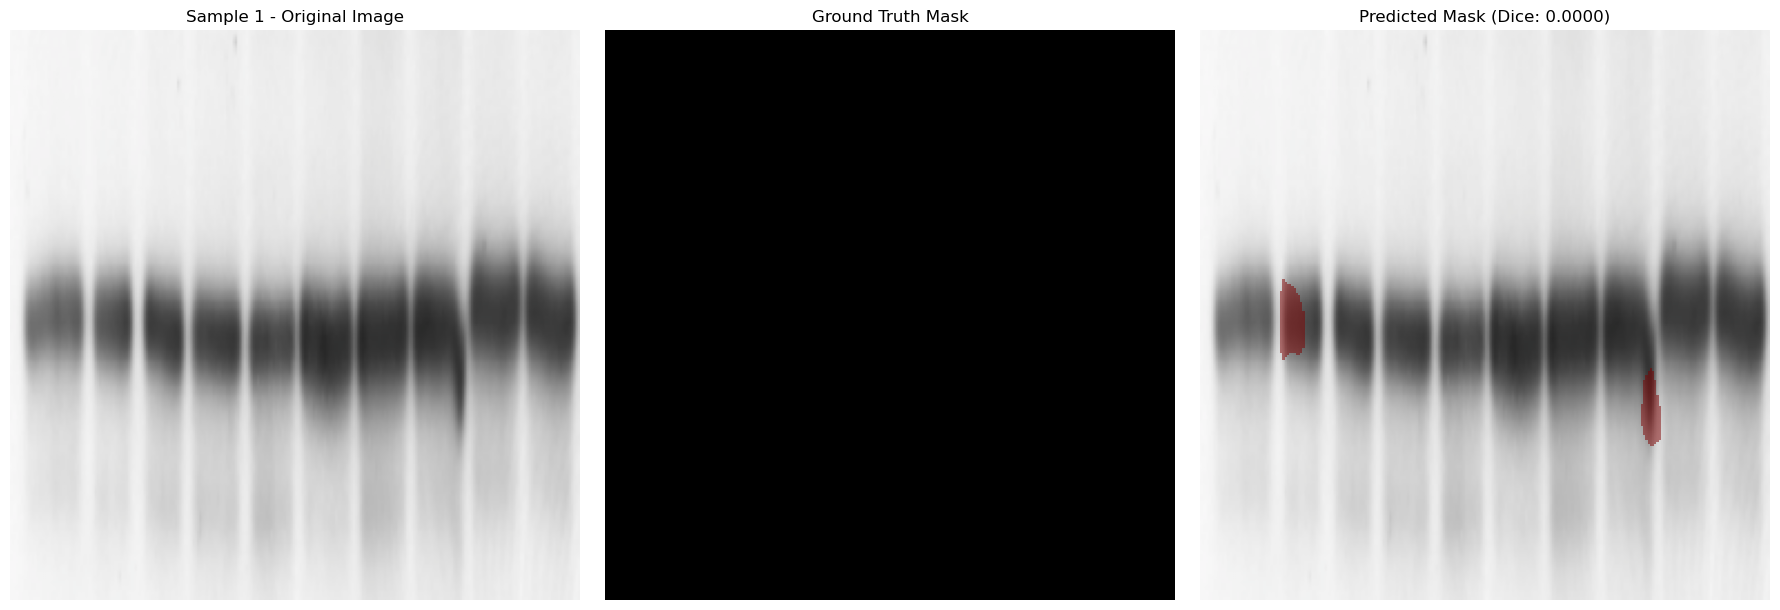

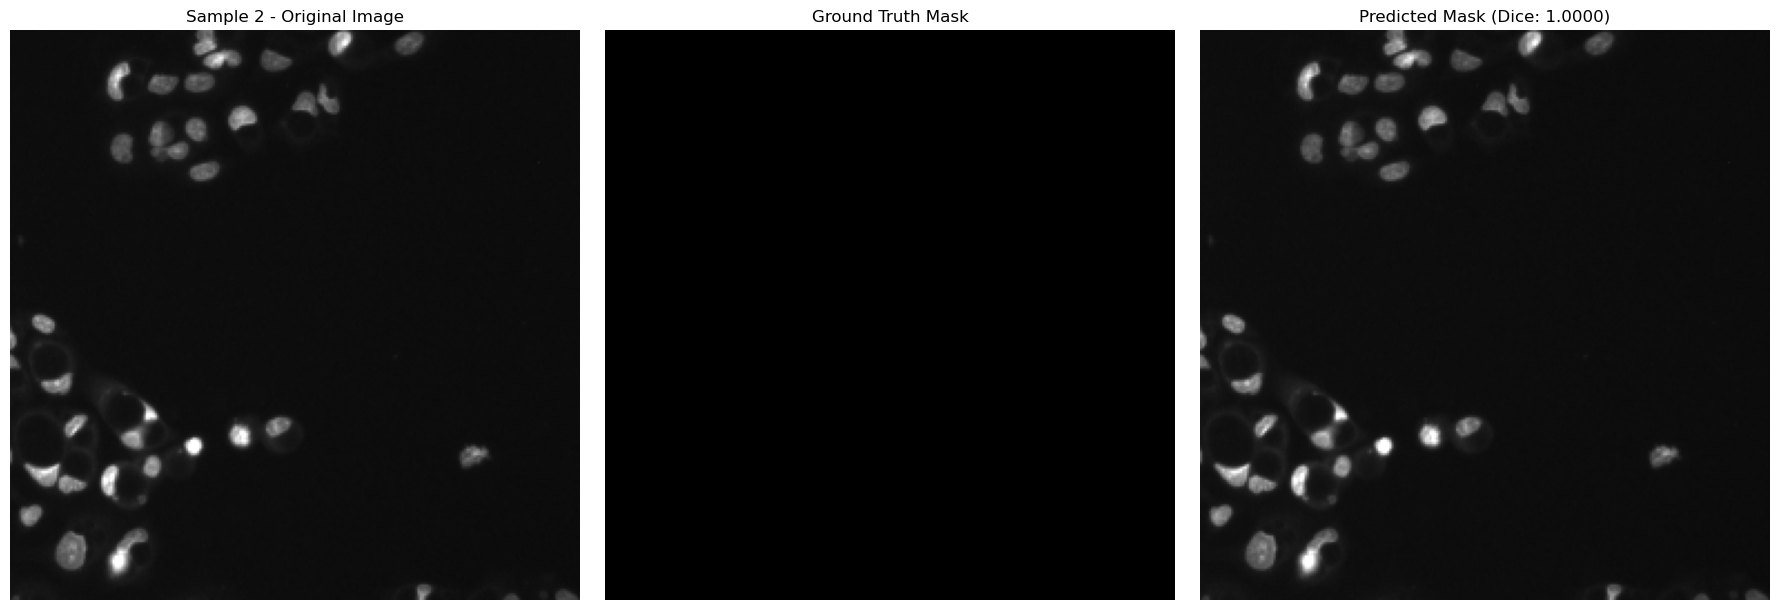

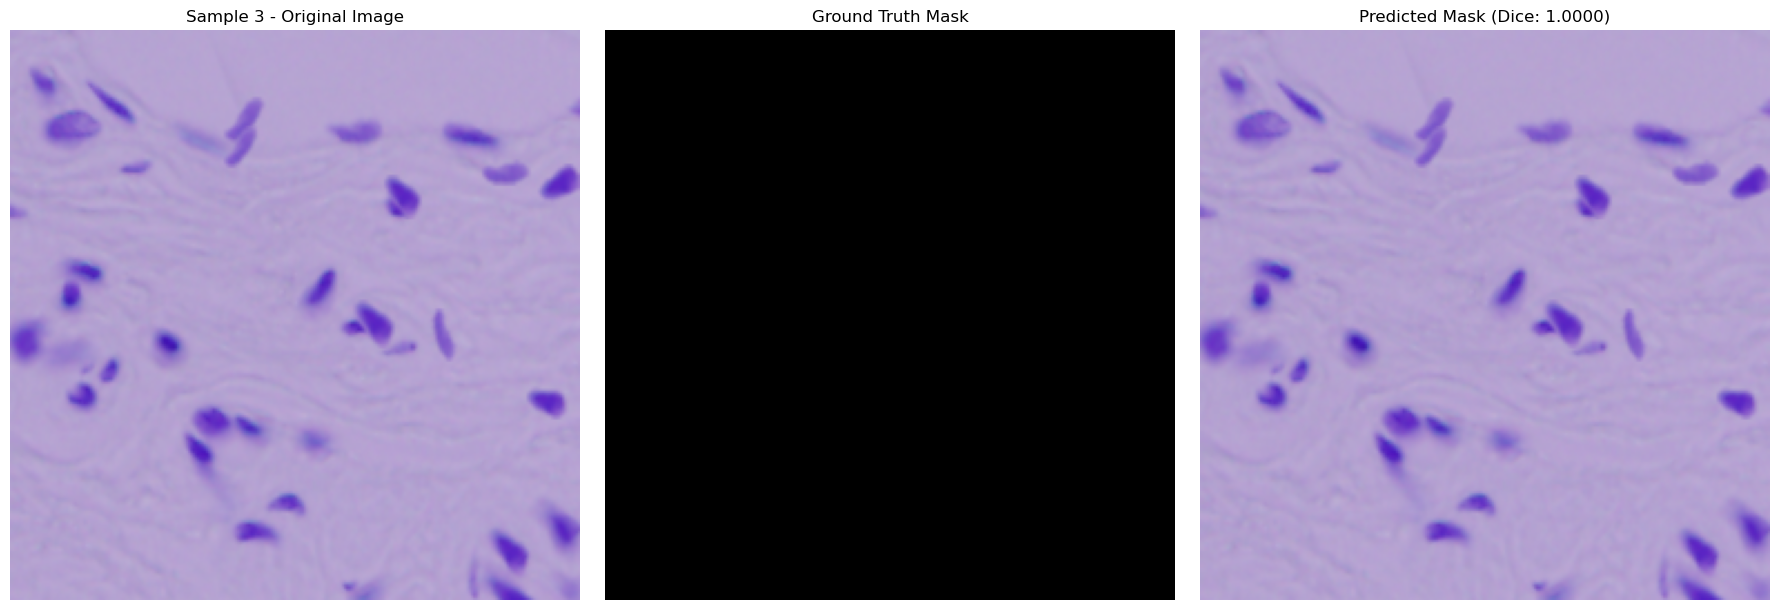

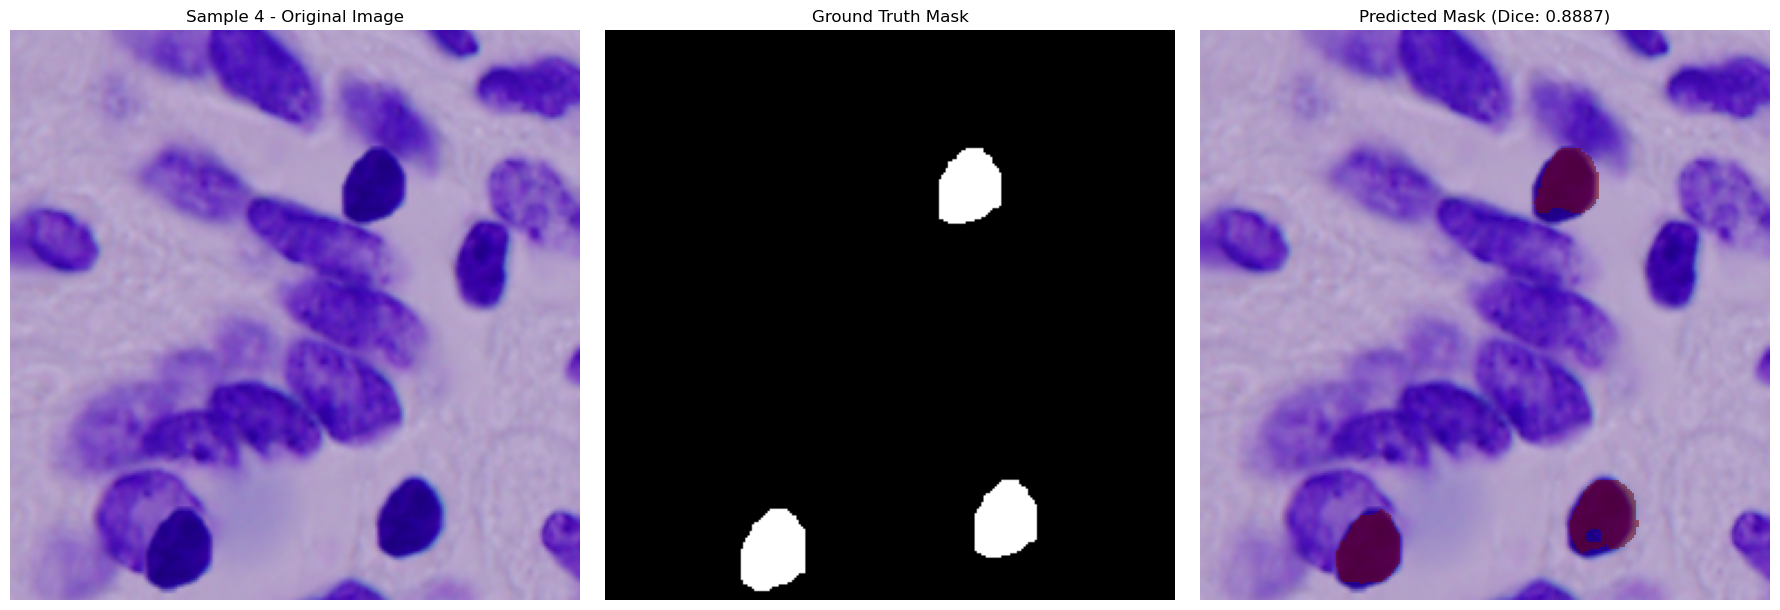

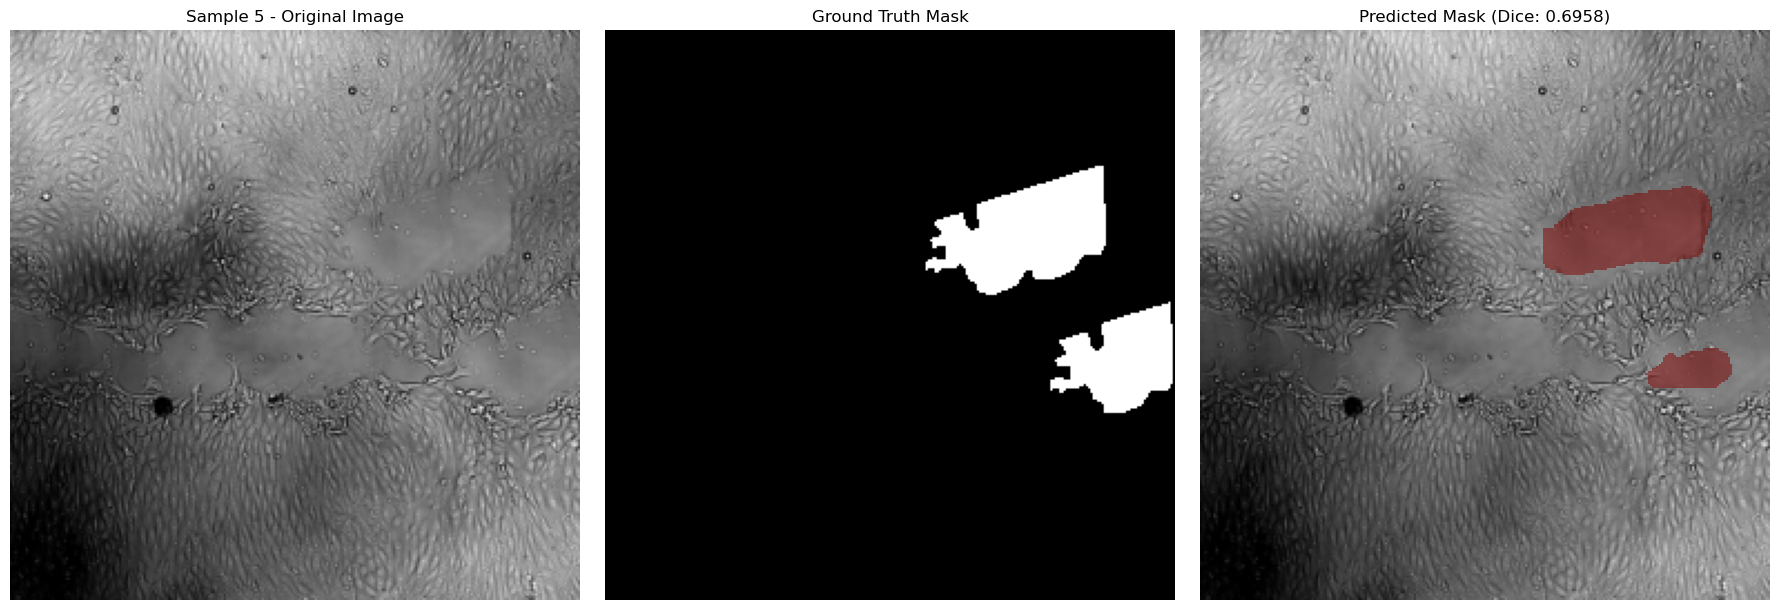

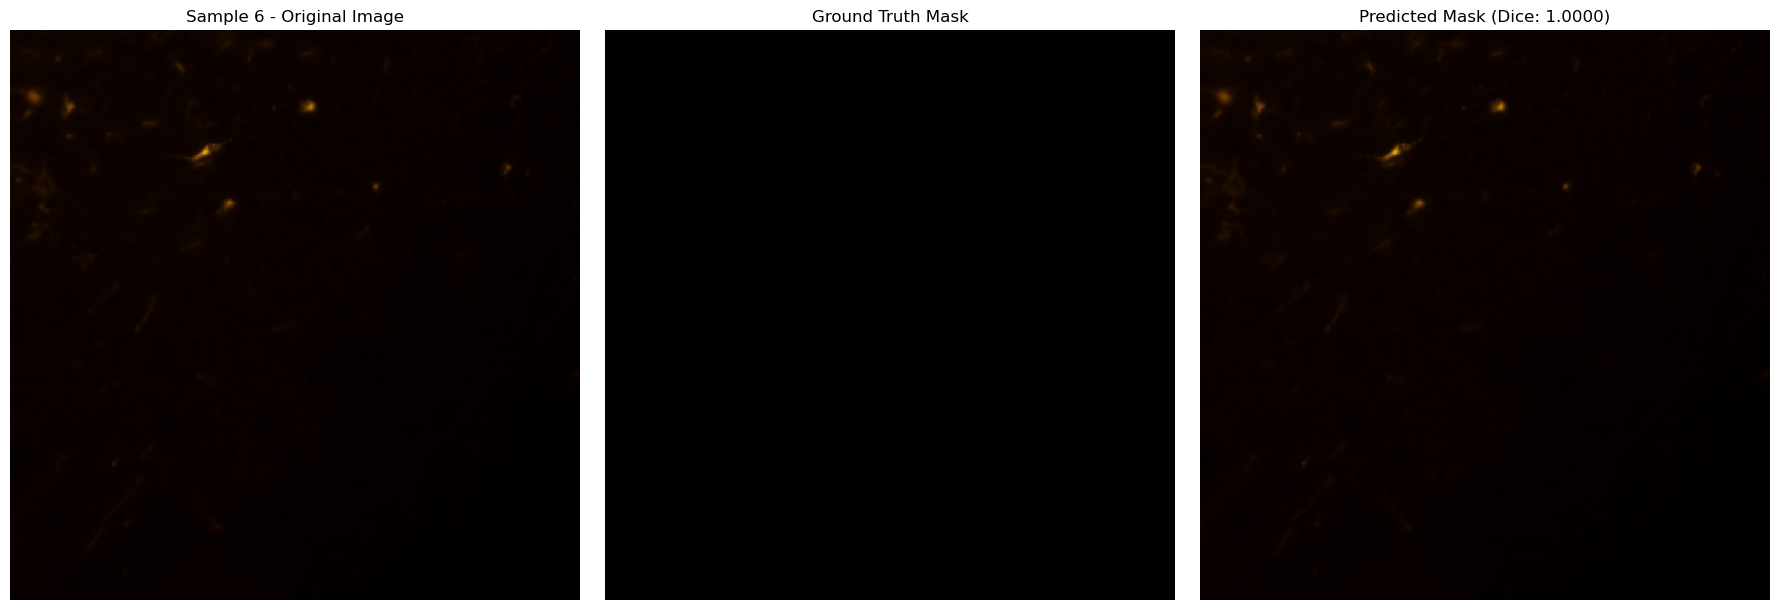

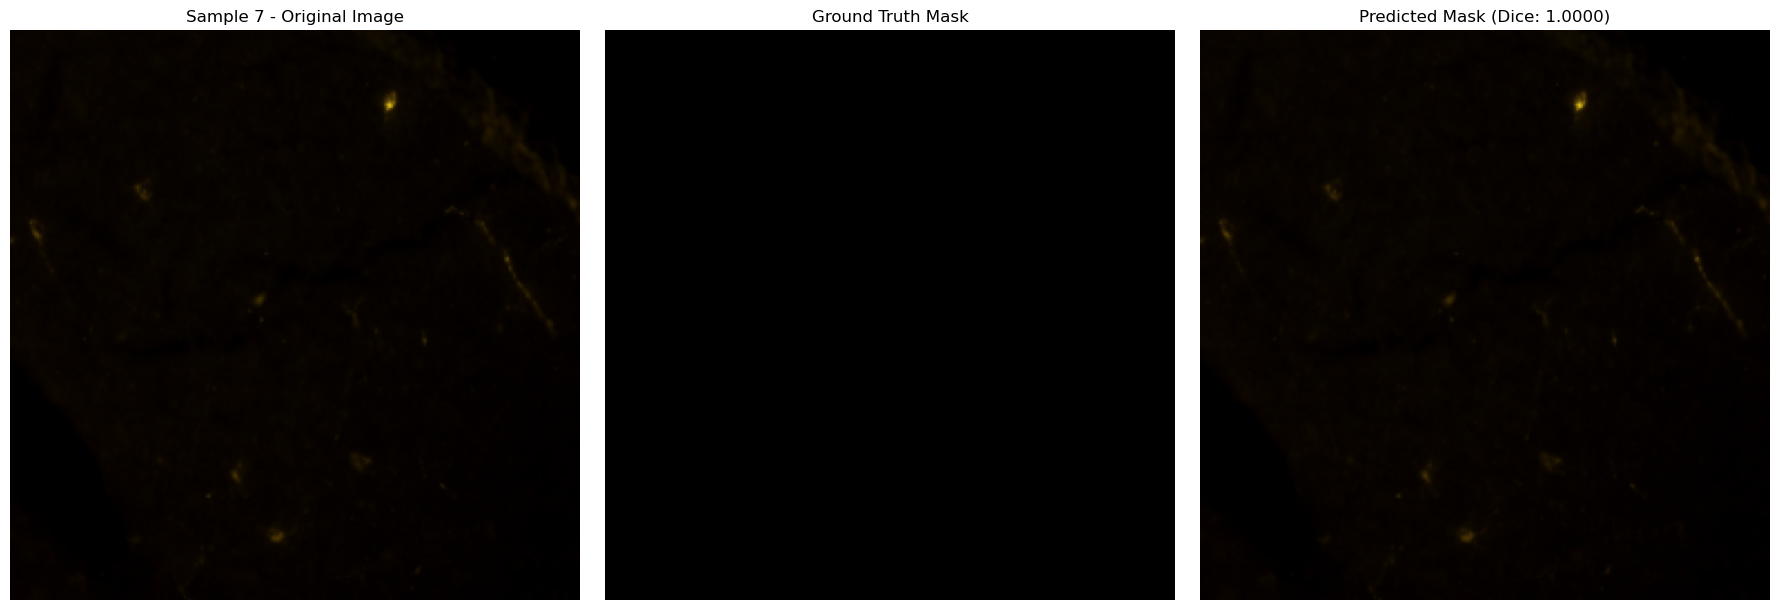

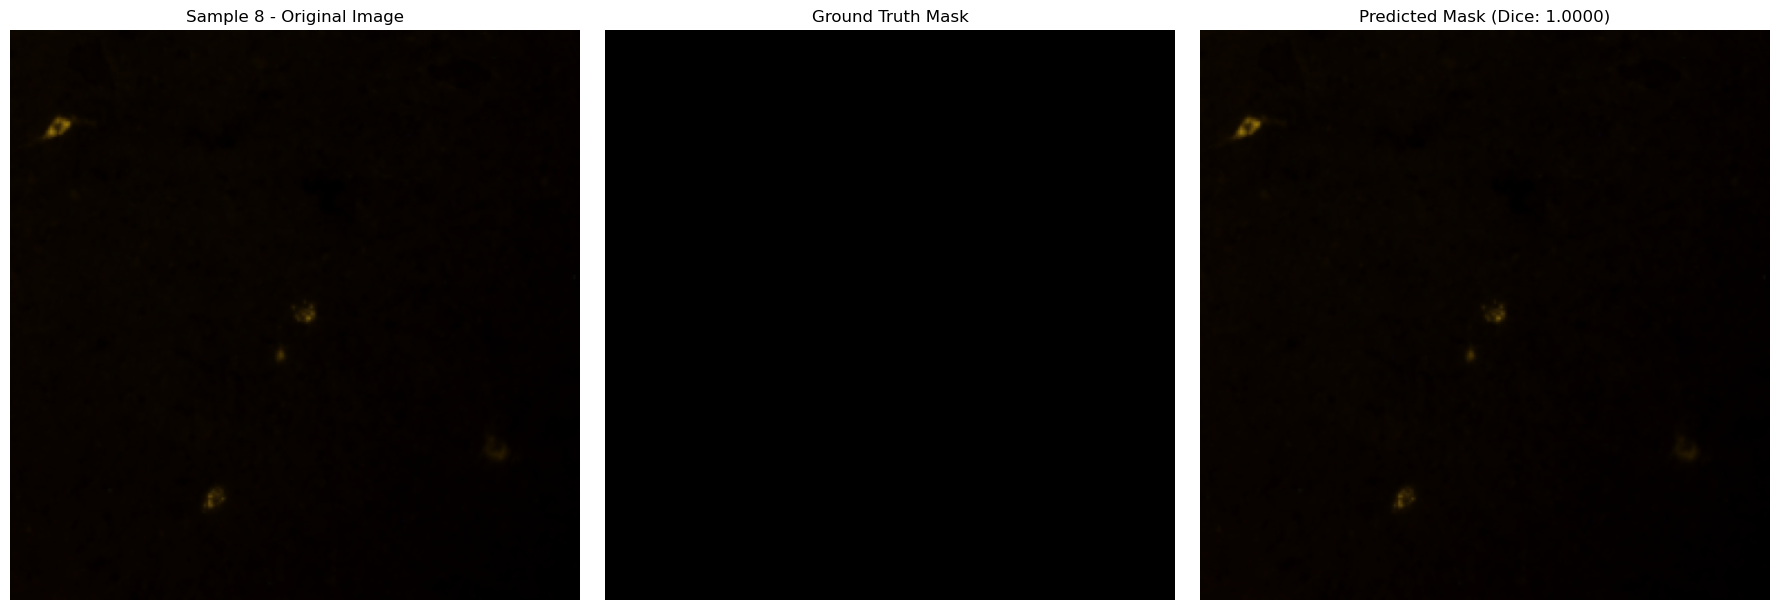

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.colors as colors
# 確保您已經定義了 dice_score 函數
custom_cmap = plt.colormaps.get_cmap('jet').copy()
custom_cmap.set_under('None', alpha=0)

# -----------------------------------------------------------
# 步驟 1: 定義反標準化參數 (請檢查您的數據集定義以確認這些值)
# -----------------------------------------------------------
# 假設您使用的是 ImageNet 標準化參數 (這是最常見的)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    """將標準化後的 tensor 轉換回原始範圍 [0, 1]"""
    # 複製 tensor 避免修改原始數據
    denorm_tensor = tensor.clone()
    
    # 調整 mean 和 std 的維度以匹配 (C, H, W)
    mean = torch.tensor(mean).view(tensor.size(0), 1, 1).to(tensor.device)
    std = torch.tensor(std).view(tensor.size(0), 1, 1).to(tensor.device)
    
    # 執行反標準化：T = T * std + mean
    denorm_tensor.mul_(std).add_(mean) 
    return denorm_tensor

# -----------------------------------------------------------
# 步驟 2: 修改視覺化函數以包含反標準化
# -----------------------------------------------------------

# dataiter = iter(val_loader) # 確保 dataiter 已經在全局範圍初始化

def visualize_next_sample(model, dataiter, device, num_samples=3):
    """
    從 dataloader 中提取並視覺化批次中的前幾個樣本 (包含反標準化)。
    """
    try:
        images, masks = next(dataiter)
    except StopIteration:
        print("所有批次樣本已查看完畢。請重新初始化 dataiter = iter(val_loader)")
        return

    images = images.to(device)
    masks = masks.to(device) 

    # 進行預測
    model.eval()
    with torch.no_grad():
        outputs = model(images) 
    
    probs = torch.sigmoid(outputs)
    predicted_masks = (probs > 0.5).float() 

    # 設置繪圖
    num_to_display = min(images.shape[0], num_samples)
    
    for i in range(num_to_display):
        
        # 我們將單張圖像 (3, H, W) 從設備移到 CPU，然後進行反標準化
        single_image = images[i].cpu()
        image_denorm = denormalize(single_image, IMAGENET_MEAN, IMAGENET_STD)
        
        # 處理圖像 (C, H, W) -> (H, W, C)，並裁剪到 [0, 1] 範圍
        image_np = image_denorm.permute(1, 2, 0).numpy()
        image_np = np.clip(image_np, 0, 1) # 確保數值在 [0, 1] 範圍

        true_mask_np = masks[i].cpu().squeeze().numpy()
        pred_mask_np = predicted_masks[i].cpu().squeeze().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 圖 1: 原始圖像
        axes[0].imshow(image_np) 
        axes[0].set_title(f"Sample {i+1} - Original Image")
        axes[0].axis('off')
        
        # 圖 2: 真實 Mask
        axes[1].imshow(true_mask_np, cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        # 圖 3: 預測 Mask
        axes[2].imshow(image_np)
        axes[2].imshow(pred_mask_np, cmap=custom_cmap, alpha=0.5, vmin=0.001, vmax=1.0, interpolation='none')

        dice = dice_score(predicted_masks[i].unsqueeze(0), masks[i].unsqueeze(0)).item()
        
        axes[2].set_title(f"Predicted Mask (Dice: {dice:.4f})")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

# 呼叫此函數來查看下一個樣本
visualize_next_sample(model, dataiter, device, num_samples=10)